In [68]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, utils,datasets
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

In [131]:
data_transform = transforms.Compose([
 transforms.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 标准化至[-1, 1]，规定均值和标准差
])

In [135]:
train_dataset = datasets.ImageFolder(root="./train",
           transform=data_transform)
test_dataset = datasets.ImageFolder(root="./test",
           transform=data_transform)

In [137]:
train_dataset[100]

(tensor([[[0.6941, 0.6627, 0.6549,  ..., 0.5529, 0.5765, 0.5922],
          [0.6627, 0.6392, 0.6314,  ..., 0.5529, 0.5686, 0.5765],
          [0.6392, 0.6235, 0.6235,  ..., 0.5529, 0.5529, 0.5529],
          ...,
          [0.7804, 0.7804, 0.7804,  ..., 0.7020, 0.6941, 0.6941],
          [0.7647, 0.7647, 0.7647,  ..., 0.6941, 0.6784, 0.6784],
          [0.7569, 0.7490, 0.7412,  ..., 0.6941, 0.6784, 0.6784]],
 
         [[0.4980, 0.4667, 0.4588,  ..., 0.3569, 0.3804, 0.3961],
          [0.4824, 0.4588, 0.4588,  ..., 0.3725, 0.3882, 0.3961],
          [0.4667, 0.4510, 0.4510,  ..., 0.3804, 0.3804, 0.3804],
          ...,
          [0.7176, 0.7176, 0.7176,  ..., 0.6627, 0.6549, 0.6549],
          [0.7020, 0.7020, 0.7020,  ..., 0.6549, 0.6392, 0.6392],
          [0.6941, 0.6863, 0.6784,  ..., 0.6549, 0.6392, 0.6392]],
 
         [[0.4667, 0.4353, 0.4275,  ..., 0.3255, 0.3490, 0.3647],
          [0.4510, 0.4275, 0.4196,  ..., 0.3333, 0.3569, 0.3569],
          [0.4275, 0.4118, 0.4118,  ...,

In [138]:
train_data = []

In [139]:
for i in range(len(train_dataset)):
    temp = torch.rand(4,32,32)
    temp[0] = train_dataset[i][0][0]
    temp[1] = train_dataset[i][0][1]
    temp[2] = train_dataset[i][0][1]
    temp[3] = train_dataset[i][0][2]
    train_data.append((temp,train_dataset[i][1]))

In [140]:
len(train_data)

50000

In [141]:
train_data[0][0].shape

torch.Size([4, 32, 32])

In [142]:
test_data=[]

In [143]:
for i in range(len(test_dataset)):
    temp = torch.rand(4,32,32)
    temp[0] = test_dataset[i][0][0]
    temp[1] = test_dataset[i][0][1]
    temp[2] = test_dataset[i][0][1]
    temp[3] = test_dataset[i][0][2]
    test_data.append((temp,i, test_dataset[1]))

In [144]:
test_data[0][0].shape

torch.Size([4, 32, 32])

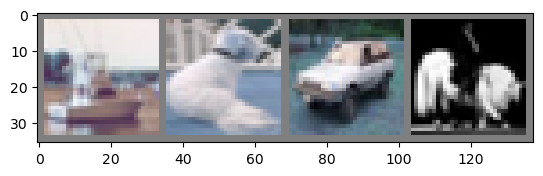

tensor([8, 5, 1, 7])


In [72]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# 显示图像
def imshow(img):
 img = img / 2 + 0.5  # unnormalize
 npimg = img.numpy()
 plt.imshow(np.transpose(npimg, (1, 2, 0)))
 plt.show()
# 随机获取部分训练数据
dataiter = iter(dataset_loader)#此处填写加载的数据集
images, labels = next(dataiter)
# 显示图像
imshow(torchvision.utils.make_grid(images))
print(labels)

In [145]:
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=True)

In [146]:
len(train_dataloader)

1563

In [147]:
from torch import nn
import torch


def _make_divisible(ch, divisor=8, min_ch=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, in_channel, out_channel, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_channel = in_channel * expand_ratio
        self.use_shortcut = stride == 1 and in_channel == out_channel

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channel, hidden_channel, kernel_size=1))
        layers.extend([
            ConvBNReLU(hidden_channel, hidden_channel, stride=stride, groups=hidden_channel),
            nn.Conv2d(hidden_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, alpha=1.0, round_nearest=8):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = _make_divisible(32 * alpha, round_nearest)
        last_channel = _make_divisible(1280 * alpha, round_nearest)

        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        features = []
        features.append(ConvBNReLU(4, input_channel, stride=2))
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * alpha, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        features.append(ConvBNReLU(input_channel, last_channel, 1))
        self.features = nn.Sequential(*features)

        # building classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [148]:
model = MobileNetV2()

In [149]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [150]:
batch_size = 64
learning_rate = 0.1
epochs = 10

In [151]:
if torch.cuda.is_available():
    model = model.cpu()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
record = {'Train Loss': [],'Test Loss': [], 'Train Acc': [], 'Test Acc': []}

for epoch in range(1, epochs+1):
    process = tqdm(train_dataloader, unit='step')
    model.train(True)
    train_loss, train_correct = 0, 0
    for step, (train_imgs, labels) in enumerate(process):
 
        model.zero_grad()  
        outputs = model(train_imgs)  
        loss = criterion(outputs, labels) 
        predictions = torch.argmax(outputs, dim=1)  
        correct = torch.sum(predictions == labels)
        accuracy = correct / labels.shape[0]  
        loss.backward()  
        optimizer.step() 
        process.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" %  
                                   (epoch, epochs, loss.item(), accuracy.item()))
 
        train_loss = train_loss + loss
        train_correct = train_correct + correct
 
        if step == len(process) - 1:
            tst_correct, totalLoss = 0, 0
            model.train(False) 
            model.eval() 
            with torch.no_grad():
                for test_imgs, test_labels in test_dataloader:
                    if torch.cuda.is_available():
                        test_imgs = test_imgs.cpu()
                        test_labels = test_labels.cpu()
                    tst_outputs = model(test_imgs)
                    tst_loss = criterion(tst_outputs, test_labels)
                    predictions = torch.argmax(tst_outputs, dim=1)
 
                    totalLoss += tst_loss
                    tst_correct += torch.sum(predictions == test_labels)

                train_accuracy = train_correct / 50000
                train_loss = train_loss / 50000

                test_accuracy = tst_correct / 10000
                test_loss = totalLoss / 10000
 
                record['Train Loss'].append(train_loss.item()) 
                record['Train Acc'].append(train_accuracy.item())
                record['Test Loss'].append(test_loss.item())
                record['Test Acc'].append(test_accuracy.item())
 
                process.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %
                                           (epoch, epochs, train_loss.item(), train_accuracy.item(), test_loss.item(),
                                            test_accuracy.item()))
    process.close()

[1/10] Loss: 2.1514, Acc: 0.1250: 100%|█████████▉| 1562/1563 [23:28<00:00,  1.11step/s]


ValueError: too many values to unpack (expected 2)